### Single Period Time Series Forecasting

During the last tests we used a forecast horizon of 12 month and we used time slice of these 12 month on the output side. This has the disadvantage that the last 12 periods of the time series we have for the training never been used as an input. So, the Neural Network does not use the early past and reacts on changes very slow.

One solution to prevent from this behavior could be to predict only one single period (one month) and use the prediction values again as input in a rolling manner, so that there is not change on the forecast horizon. 

This notebook shows how to solve this.

#### Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from IPython.display import display

seed=8172
np.random.seed(seed)
tf.random.set_seed(seed)
ts_input_size=12
ts_target_size=1
forecast_size=12
# Read the data
df=pd.read_csv("../data/AirPassengers.csv")
df.columns=["Period","Passengers"]
dfTraining=df.iloc[:-forecast_size].copy()

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0.1, 0.9))
series_scaled = scaler.fit_transform(dfTraining["Passengers"].values.reshape(-1,1))
dfTraining["PassengersScaled"]=series_scaled
display(dfTraining.head(5))
display(dfTraining.tail(5))

,Period,Passengers,PassengersScaled
0,1949-01,112,0.114066
1,1949-02,118,0.124615
2,1949-03,132,0.149231
3,1949-04,129,0.143956
4,1949-05,121,0.129890


,Period,Passengers,PassengersScaled
127,1959-08,559,0.900000
128,1959-09,463,0.731209
129,1959-10,407,0.632747
130,1959-11,362,0.553626
131,1959-12,405,0.629231


Setting the traget size to 1 period element reduces the missing gap at the end of the training data

In [2]:

training_flat=dfTraining["PassengersScaled"].values.reshape(-1,1).astype("float32")
trainX=[]
trainY=[]
for i in range(len(training_flat)-ts_target_size-ts_input_size+1):
    x=training_flat[i:(i+ts_input_size),0]
    y=training_flat[(i+ts_input_size):(i+ts_input_size+ts_target_size),0]
    trainX.append(x)
    trainY.append(y)

# Training data
trainX=np.array(trainX)
trainY=np.array(trainY)
from sklearn.model_selection import train_test_split
x_trainbatches, x_testbatches, y_trainbatches, y_testbatches = train_test_split(
            trainX, trainY, test_size=0.1, random_state=42)
x_testbatches

# Forecast input
predictX=[training_flat[-ts_input_size:,0]]
predictX

[array([0.55010986, 0.5184615 , 0.630989  , 0.6134066 , 0.6556044 ,
        0.74703294, 0.88065934, 0.9       , 0.7312088 , 0.63274723,
        0.55362636, 0.6292308 ], dtype=float32)]

In [3]:
display(dfTraining.tail(14))
print("Last observation X: {}".format(trainX[-1]))
print("Last observation Y: {}".format(trainY[-1]))

,Period,Passengers,PassengersScaled
118,1958-11,310,0.462198
119,1958-12,337,0.509670
120,1959-01,360,0.550110
121,1959-02,342,0.518462
122,1959-03,406,0.630989
123,1959-04,396,0.613407
124,1959-05,420,0.655604
125,1959-06,472,0.747033
126,1959-07,548,0.880659
127,1959-08,559,0.900000


Last observation X: [0.5096703  0.55010986 0.5184615  0.630989   0.6134066  0.6556044
 0.74703294 0.88065934 0.9        0.7312088  0.63274723 0.55362636]
Last observation Y: [0.6292308]


Next, there are some functions for the reports and also for the training process. The functions were already used in the notebooks before

In [4]:
def show_loss(history,skipFirst=True):
    print("Last Results loss:{}, cross validation loss:{}".format(history.history['loss'][-1],history.history['val_loss'][-1]))
    plt.figure(figsize=(20,10))
    start=100 if skipFirst else 0
    plt.plot(history.history["val_loss"][start:], label="Cross Validation Loss")
    plt.plot(history.history["loss"][start:], label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss Results - Training vs. Cross Validation (Mean Squared Error)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()  

def show_results(df,predictX,predictY):
    outputsize=len(predictY[0])
    inputsize=len(predictX[0])
    absDeviation=np.sum(np.abs(df["Passengers"].values[-outputsize:]-predictY[0]))
    absError=absDeviation/np.sum(predictY[0])*100
    print("          Forecast : {}\r\n            Actual : {}\r\nAbsolute Deviation : {} Passengers\r\n    Absolute Error : {:3.2f}%".format(
        predictY.astype(int)[0],df["Passengers"].values[-outputsize:],absDeviation,absError))    
    y0=df["Passengers"].values
    y1=[None for x in range(df.shape[0]-outputsize-inputsize)]
    y1.extend(predictX[0])
    y1=np.array(y1)
    y2=[None for x in range(df.shape[0]-outputsize)]
    y2.extend(predictY[0])
    y2=np.array(y2)
    plt.figure(figsize=(20,10))
    plt.plot(y0,label='Actual')
    plt.plot(y1,label='Input for Forecast')
    plt.plot(y2, label= 'Forecast')
    plt.xlabel("Period")
    labels=[df["Period"].iloc[x] for x in range(0,df.shape[0],12)]
    plt.xticks(range(0,df.shape[0],12),labels=labels, rotation=45)
    plt.ylabel("Number of Passenger")
    plt.title("Forecast Airline Passenger")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()    


def buildAndTrainModel(layerSize1,layerSize2, usebias=True):
    model=keras.Sequential()
    model.add(keras.layers.Dense(layerSize1,activation=keras.layers.LeakyReLU(), input_dim=ts_input_size, use_bias=usebias))
    if layerSize2 is not None:
        model.add(keras.layers.Dense(layerSize2,activation=keras.layers.LeakyReLU(), use_bias=usebias))
    model.add(keras.layers.Dense(ts_target_size, activation=keras.layers.LeakyReLU(), use_bias=usebias))

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )
    earlyStopCB= keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=300,verbose=0,mode='auto')
    history=model.fit(x_trainbatches, y_trainbatches, epochs=10000,verbose=0,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               use_multiprocessing=True, callbacks=[earlyStopCB])
    return model,history



In [5]:
model,history=buildAndTrainModel(67,13,True)

Last Results loss:0.0005128701450303197, cross validation loss:0.00046421829028986394


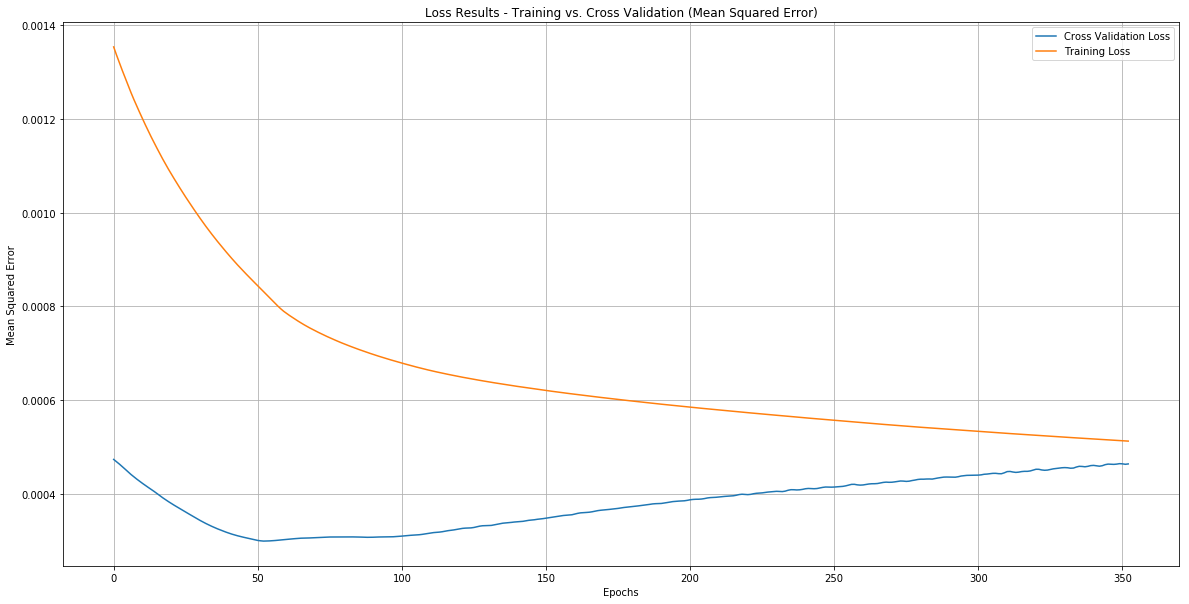

In [6]:
show_loss(history)

#### Rolling Forecasts

As we only predict one period with the current model, the predicted values from previous periods must be used as input for the next periods.

In [7]:
predictInput=np.array(predictX)
print(predictInput)
predictOutput=model.predict(predictInput)
print(predictOutput)

[[0.55010986 0.5184615  0.630989   0.6134066  0.6556044  0.74703294
  0.88065934 0.9        0.7312088  0.63274723 0.55362636 0.6292308 ]]
[[0.622093]]


First make a prediction and then append the new values and shorten the array again to the input size

In [8]:
print(np.reshape(np.append(predictInput[-1,ts_target_size:],predictOutput),(1,-1)))

[[0.5184615  0.630989   0.6134066  0.6556044  0.74703294 0.88065934
  0.9        0.7312088  0.63274723 0.55362636 0.6292308  0.622093  ]]


A function wich does this for the whole forecast horizon

          Forecast : [400 387 419 428 459 513 593 606 531 450 406 436]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 171.61972045898438 Passengers
    Absolute Error : 3.05%


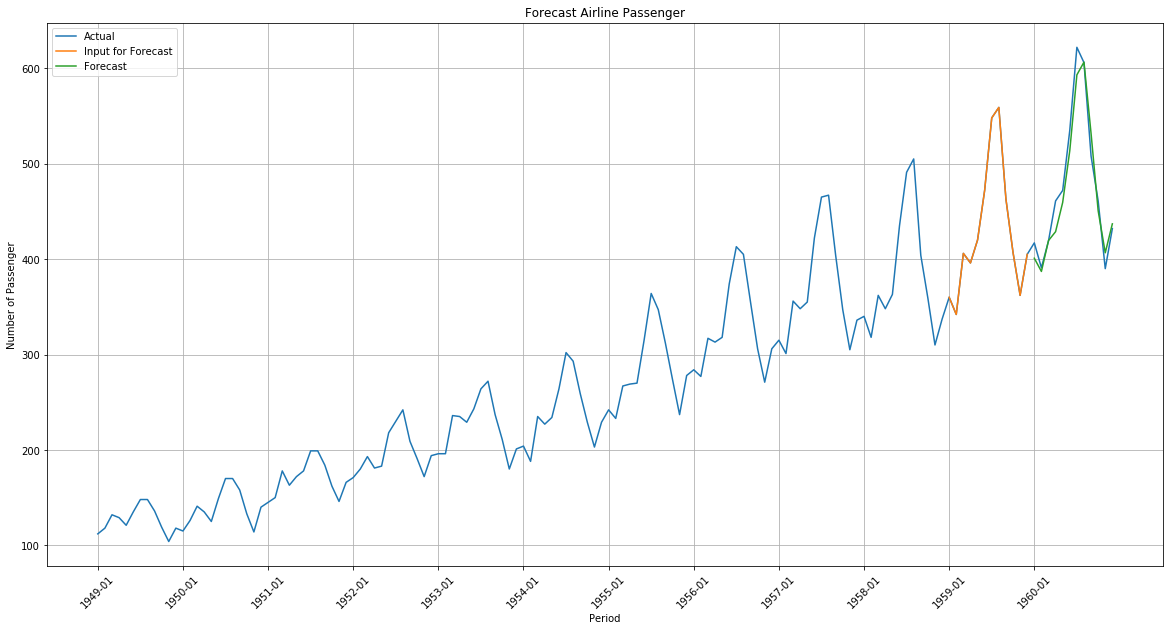

In [9]:
def predict(model, predictX, forecast_size,ts_target_size):
    result =None
    predictInput=np.array(predictX)
    for loop in range(0,forecast_size,ts_target_size):
        predictOutput=model.predict(predictInput)
        result=predictOutput if result is None else np.append(result,predictOutput)
        predictInput=np.reshape(np.append(predictInput[-1,ts_target_size:],predictOutput),(1,-1))
    return np.reshape(result,(1,-1))

predictY=predict(model,predictX,forecast_size,ts_target_size)
show_results(df,scaler.inverse_transform(predictX),scaler.inverse_transform(predictY))
      

### Conclusio

This method enables large forecasting horizons and you lose only one period value at the end of your training set. This gives you more observations. As it can been seen the overall error is still quiet low. But this is also a critical method, because it can lead to build-up errors. This occurs especially when the forecasts are only based on forecasts and the entire forecast period is very long 